## Define the initial parameters for the function
* Timesteps will be used to determine how many timesteps the model should run through
* World variable defines which hypothesis the true one, the "new" one or "old" one.

In [90]:
# Define graph structure parameters
population = 10
graphShape = "wheel" # can be "cycle", "complete", or "wheel"

# Define simulation parameters
timesteps = 100
world = 'new' # can be "new" or "old"


## Import libraries and define `ScientistNode` class
Libraries include networkx for graph data analysis and matplotlib for data visualization.
The custom node class is defined for keeping track of the data for a scientist within the network.

In [91]:
# import packages
import networkx as nx
import random



## Define timestep function
This function will be run for every timestep, taking in the graph data structure as an argument.

In [92]:
from helpers import calculate_posterior
from typing import Literal

# Define how to run an experiment
# Question, is this being done correctly?
def run_experiment(worldState: Literal['new', 'old']):
    return random.uniform(0.3, 0.8) if worldState == 'new' else random.uniform(0.2, 0.7)

def timestep(graph: nx.Graph):
    # Get node data
    nodes = graph.nodes(data=True)
    for node, data in nodes:
        # run a new experiment if the scientist has a greater than 50% belief that the hypothesis is true
        data['pEH'] = run_experiment(worldState=world) if data['beliefProb'] > 0.5 else None
        data['beliefProb'] = calculate_posterior(data['beliefProb'], data['pEH']) if data['pEH'] is not None else data['beliefProb']

    # update the scientists belief probability based on the observed evidence from their neighbors
    for node, data in nodes:
        neighbors = graph.neighbors(node)
        for neighbor in neighbors:
            neighbor_data = graph.nodes[neighbor]
            if neighbor_data['pEH'] is not None:
                data['beliefProb'] = calculate_posterior(data['beliefProb'], neighbor_data['pEH'])
        data['group'] = sum(data['beliefProb'] > x for x in [0, 0.4, 0.6, 1])
    return graph

## Initialize the graph
Initialize the graph with the defined shape set by the `graphShape` and `population` variables

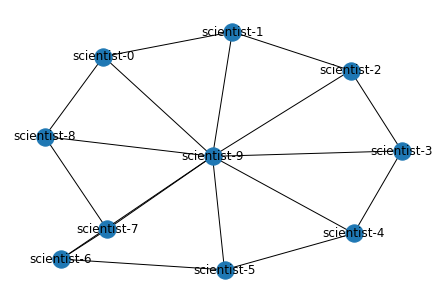

In [98]:
from helpers import initialize_graph

graph = initialize_graph(graphType=graphShape, numNodes=population)
nx.draw(graph, with_labels=True)

## Run the simulation
Run the simulation using the intialized graph, the `timestep` function defined above and the `timesteps` variable

In [ ]:
from helpers import run_simulation

results = run_simulation(graph=graph, timestep_func=timestep, num_timesteps=timesteps)